<a href="https://colab.research.google.com/github/Zoey-Wu-ed/Text-Calssification-in-Practice-From-Topic-Models-to-Transformers/blob/main/Task2-LSTM-EcommerceClassification/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification: Long Short Term Memory networks​**

## Introduction to LSTM Models

Long Short-Term Memory (LSTM) networks are a specialised type of Recurrent Neural Network (RNN) designed to learn from sequential data while addressing the vanishing and exploding gradient problems common in traditional RNNs. Unlike standard RNNs, which struggle to retain information over long sequences, LSTMs introduce a mechanism called memory cells equipped with gates that regulate information flow.




![LSTM.png](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ahafyNt0Ph_J6Ed9_2hvdg.png)

An LSTM unit contains three key gates:

- Forget Gate: decides which information from the previous state should be discarded.
- Input Gate: determines which new information will be stored in the cell state.
- Output Gate: controls which part of the internal cell state should be exposed as output.

These gates are implemented using sigmoid and tanh activation functions, enabling the network to maintain, update, or reset information selectively. This architecture allows LSTMs to capture long-term dependencies in data sequences — making them effective in domains like natural language processing, speech recognition, and time-series forecasting.

In essence, the LSTM model learns what to remember and what to forget over time, enabling robust modeling of complex temporal behaviors that standard RNNs cannot easily represent.

Materials related to the LSTM model:

*   https://colah.github.io/posts/2015-08-Understanding-LSTMs/
*   https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2



In [ ]:
# =============================
# Environment and Basic Setup (Colab)
# =============================
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/TextClassification/Codes/'
!nvidia-smi

import warnings
warnings.filterwarnings("ignore")

# =============================
# Imports
# =============================
import os
import re
import itertools
import random
import copy
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score)

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive/
/content/drive/MyDrive/TextClassification/Codes
/bin/bash: line 1: nvidia-smi: command not found


The dataset we will use today:
https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

This is an E-commerce text dataset for 4 categories - "Electronics", "Household", "Books" and "Clothing & Accessories", which almost cover 80% of any E-commerce website.

The dataset is in ".csv" format with two columns - the first column is the class name and the second one is the datapoint of that class. The data point is the product and description from the e-commerce website.

Gautam. (2019). E commerce text dataset (version - 2) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.3355823


In [ ]:
# =============================
# Seed Control
# =============================
def setup_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =============================
# Configuration
# =============================
CFG = {
    "data_path": "../Data/ecommerceDataset.csv",

    # default values
    "embed_dim": 300,
    "hidden_dim": 128,
    "dropout": 0.2,
    "num_layers": 2,
    "bidirectional": True,

    "epochs": 30,
    "patience": 6,

    # default train setup
    "batch_size": 32,
    "lr": 1e-4,

    # ========== Hyperparameter grid ==========
    "grid": {
        "batch_size": [32, 64],
        "lr": [1e-5,1e-4,1e-3]},

    "random_seeds": [42],
}

In [ ]:
# =============================
# Load Dataset
# =============================
df = pd.read_csv(CFG["data_path"])
df.columns = ['label', 'text']
print("Preview:")
display(df.head())

Preview:


,label,text
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts t..."
1,Household,"SAF 'UV Textured Modern Art Print Framed' Painting (Synthetic, 35 cm x 50 cm x 3 cm, Set of 3) Color:Multicolor | ..."
2,Household,"SAF Flower Print Framed Painting (Synthetic, 13.5 inch x 22 inch, UV Textured, Set of 3, SANFSW4951) Color:Multicolor ..."
3,Household,"Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift (5 X 4 Inch) Size:4 x 5 Made Of Natural Imported Wood, Which Is Quite Solid With Light Particle Pattern & Is Soft Pale To Bl..."
4,Household,Pitaara Box Romantic Venice Canvas Painting 6mm Thick Mdf Frame 21.1 X 14Inch Enclosure Material:MDF Mount Frame | ...


In [ ]:
df.label.value_counts()

,count
label,
Household,19312
Books,11820
Electronics,10621
Clothing & Accessories,8671


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50424 non-null  object
 1   text    50423 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50423 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50423 non-null  object
 1   text    50423 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
# =============================
# Text Cleaning
# =============================
def clean_text(text: str) -> str:
    # convert to lowercase
    text = text.lower()
    # replace all non-alphanumeric characters with space
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # collapse multiple spaces and trim
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Give you an example
print(df['text'][1])
print('After cleaning: ')
print(clean_text(df['text'][1]))

SAF 'UV Textured Modern Art Print Framed' Painting (Synthetic, 35 cm x 50 cm x 3 cm, Set of 3) Color:Multicolor                                                                                 |                            Size:35 cm x 50 cm x 3 cm   Overview a beautiful painting involves the action or skill of using paint in the right manner; hence, the end product will be a picture that can speak a thousand words they say. Arts have been in trend for quite some time now. It can give different viewer different meanings style and design the SAF wood matte abstract painting with frame is quite abstract and mysteriously beautiful. The painting has a nice frame to it. You can gift this to a family or a friend. The painting has various forms of certain figures on it as seen in the image. You can add a good set of lights to the place where the painting is and the decor will give a different feel and look to the place. Quality and durability the painting has a matte finish and includes a good 

In [ ]:
df['text'] = df['text'].astype(str).apply(clean_text)
df.head()

,label,text
0,Household,saf floral framed painting wood 30 inch x 10 inch special effect uv print textured sao297 painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards ...
1,Household,saf uv textured modern art print framed painting synthetic 35 cm x 50 cm x 3 cm set of 3 color multicolor size 35 cm x 50 cm x 3 cm overview a beautiful painting involves the action or skill of us...
2,Household,saf flower print framed painting synthetic 13 5 inch x 22 inch uv textured set of 3 sanfsw4951 color multicolor size 35 cm x 50 cm x 2 cm a beautiful painting involves the action or skill of using...
3,Household,incredible gifts india wooden happy birthday unique personalized gift 5 x 4 inch size 4 x 5 made of natural imported wood which is quite solid with light particle pattern is soft pale to blond col...
4,Household,pitaara box romantic venice canvas painting 6mm thick mdf frame 21 1 x 14inch enclosure material mdf mount frame size 21 1inch x 14inch 53 6cms x 35 6cms size 21 1 inch x 14 0 inch 53 6 cms x 35 6...


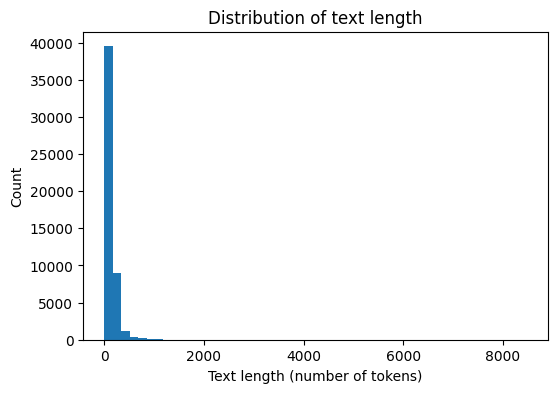

In [ ]:
# compute text length
df['text_len'] = df['text'].apply(lambda x: len(x.split()))

# plot distribution
plt.figure(figsize=(6, 4))
plt.hist(df['text_len'], bins=50)      # histogram of text lengths
plt.xlabel("Text length (number of tokens)")
plt.ylabel("Count")
plt.title("Distribution of text length")
plt.show()

In [ ]:
df['text_len'].quantile([0.5, 0.9, 0.95, 0.99])

,text_len
0.50,80.00
0.90,260.00
0.95,321.00
0.99,636.78


In [ ]:
# =============================
# Label Encoding
# =============================
le = LabelEncoder() # create a label encoder
df['label_id'] = le.fit_transform(df['label']) # convert string labels to numeric IDs
df.label_id.value_counts()

,count
label_id,
3,19312
0,11820
2,10621
1,8670


In [ ]:
num_classes=len(le.classes_)
print(f'We have {num_classes} classes')

We have 4 classes


In [ ]:
# =============================
# Train / Val / Test Split
# =============================
# We want Train:Val:Test = 6:2:2
# split into train (60%) and temp (40%)
train_df, temp_df = train_test_split(
    df, test_size=0.4, stratify=df['label_id'], random_state=42)

# split temp into validation (20%) and test (20%)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label_id'], random_state=42)

print(len(train_df), len(val_df), len(test_df))

30253 10085 10085




> Question: Why we use stratify=df['label_id'] here?



In [ ]:
train_df.head()

,label,text,text_len,label_id
26636,Books,trump think like a billionaire,5,0
35358,Clothing & Accessories,vivid bharti men s black grey fleece tracksuits vivid bharti is one of the best indian online garments stores that offer exclusive range of current fashion based apparels for men women girls boys ...,157,1
22143,Books,ugc net jrf exam solved papers psychology it is a book,11,0
41396,Electronics,sony mrw s1 uhs ii sd memory card reader black the mrw s1 memory card reader is the perfect solution to drastically improve workflow efficiency after shooting by quickly transferring large data fr...,44,2
13676,Household,prestige prm 2 0 1200 watt roti maker with demo cd silver black the prestige roti maker for your kitchen is the best decision you ll ever be making with a non stick base its designed in such a way...,115,3


In [ ]:
train_df['text_len'].quantile([0.5, 0.9, 0.95, 0.99])

,text_len
0.50,80.0
0.90,261.0
0.95,320.0
0.99,642.0


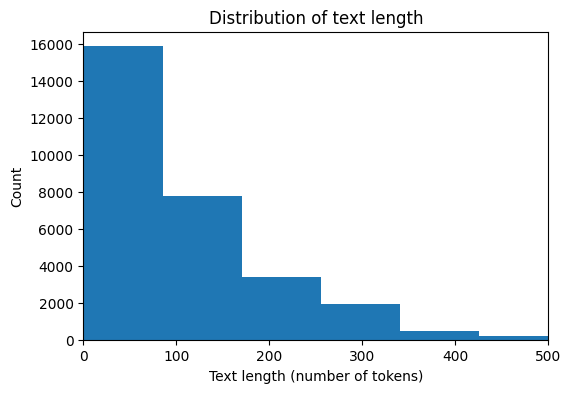

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(train_df['text_len'], bins=100)
plt.xlabel("Text length (number of tokens)")
plt.ylabel("Count")
plt.title("Distribution of text length")
# fix x-axis range to 0–500
plt.xlim(0, 500)
plt.show()

In [ ]:
# =============================
# Vocabulary
# =============================
class Vocab:
    def __init__(self, texts, min_freq=1):
        # Count word frequency across all texts
        freq = {}
        for t in texts:
            for w in t.split():
                freq[w] = freq.get(w, 0) + 1 # Increment word frequency

        # Initialize vocabulary with special tokens
        # <pad> = 0, <unk> = 1
        self.word2idx = {"<pad>": 0, "<unk>": 1}

        # Add words that meet the minimum frequency requirement
        for w, c in freq.items():
            if c >= min_freq:
                self.word2idx[w] = len(self.word2idx)

        # Build reverse mapping for decoding indices back to words
        self.idx2word = {i: w for w, i in self.word2idx.items()}

    def encode(self, text):
        # Convert a text string into a list of indices
        # Words not in the vocabulary map to <unk> (index 1)
        return [self.word2idx.get(w, 1) for w in text.split()]

# Build the vocabulary from the training text column
vocab = Vocab(train_df['text'])

vocab_size = len(vocab.word2idx)
print("Vocabulary size:", vocab_size)
print(vocab.word2idx)

Vocabulary size: 66478
{'<pad>': 0, '<unk>': 1, 'trump': 2, 'think': 3, 'like': 4, 'a': 5, 'billionaire': 6, 'vivid': 7, 'bharti': 8, 'men': 9, 's': 10, 'black': 11, 'grey': 12, 'fleece': 13, 'tracksuits': 14, 'is': 15, 'one': 16, 'of': 17, 'the': 18, 'best': 19, 'indian': 20, 'online': 21, 'garments': 22, 'stores': 23, 'that': 24, 'offer': 25, 'exclusive': 26, 'range': 27, 'current': 28, 'fashion': 29, 'based': 30, 'apparels': 31, 'for': 32, 'women': 33, 'girls': 34, 'boys': 35, 'teenagers': 36, 'and': 37, 'children': 38, 'store': 39, 'houses': 40, 'huge': 41, 'collection': 42, 'number': 43, 'made': 44, 'stylish': 45, 'fabric': 46, 'including': 47, 't': 48, 'shirts': 49, 'lowers': 50, 'sweatshirts': 51, 'plus': 52, 'jackets': 53, 'it': 54, 'night': 55, 'suits': 56, 'leggings': 57, 'as': 58, 'well': 59, 'clothes': 60, 'are': 61, 'crafted': 62, 'out': 63, 'smooth': 64, 'cotton': 65, 'which': 66, 'comfortable': 67, 'to': 68, 'wear': 69, 'has': 70, 'offers': 71, 'trendy': 72, 'both': 73, 




> Question: Why we only build the vocabulary for training set?








In [ ]:
# =============================
# Dataset & DataLoader
# =============================
class TextDataset(Dataset):
    def __init__(self, df, vocab, max_len=200):
        # Extract text and label columns from the dataframe
        self.texts = df['text'].tolist()
        self.labels = df['label_id'].tolist()

        # Store vocabulary object and maximum sequence length
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        # Total number of samples in the dataset
        return len(self.texts)

    def pad(self, seq):
        # Pad or truncate a sequence to max_len
        if len(seq) < self.max_len:
            seq = seq + [0] * (self.max_len - len(seq)) # Pad with <pad> index (0)
        else:
            seq = seq[:self.max_len]              # Truncate if too long
        return seq

    def __getitem__(self, idx):
        # Encode text into index sequence
        encoded = self.vocab.encode(self.texts[idx])

        # Apply padding or truncation
        padded = self.pad(encoded)

        # Return tensors: (input_ids, label)
        return torch.tensor(padded), torch.tensor(self.labels[idx])

In [ ]:
# An example
aa = TextDataset(train_df, vocab)
print(aa[1])
print(aa[1][0].shape) # x.shape

(tensor([ 7,  8,  9, 10, 11, 12, 13, 14,  7,  8, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 17, 28, 29, 30, 31, 32,  9, 33, 34, 35, 36, 37, 38,
        21, 39, 40, 41, 42, 17,  5, 43, 17, 31, 44, 17, 45, 46, 47, 48, 49, 50,
        14, 51, 52, 53, 32,  9, 54, 23, 14, 53, 55, 56, 57, 37, 50, 32, 33, 58,
        59, 58,  9, 18, 60, 61, 62, 63, 17, 64, 65, 46, 66, 61, 67, 68, 69, 54,
        70, 41, 42, 32, 14, 50, 37, 53, 32, 35, 52, 14, 37, 53, 32, 34, 54, 71,
        18, 72, 22, 32, 73, 74, 37, 75, 76, 54, 15, 77, 78, 21, 39, 32, 29, 79,
        80, 81, 18, 31, 54, 82, 21, 61, 83, 84, 37, 85, 86, 87, 88, 80, 89, 90,
        29, 37, 91, 92, 93, 94, 61, 95, 96, 97, 37, 98, 99,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]), tensor(1))
torch.Size([200])


In [ ]:
# ===================================================
# Model
# ===================================================
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes,
                 num_layers, dropout, bidirectional=True):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0) # embedding layer for token IDs

        self.lstm = nn.LSTM(
            embed_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional, # bidirectional LSTM encoder
            dropout=dropout if num_layers > 1 else 0.0
        )

        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, num_classes) # final classifier layer

    def forward(self, x):
        # x.shape = (batch_size, seq_len)
        x = self.embedding(x) # convert token indices to embeddings
        # x.shape = (batch_size, seq_len, embed_dim)
        _, (hn, _) = self.lstm(x) # LSTM outputs and hidden states

        if self.lstm.bidirectional:
            h = torch.cat((hn[-2], hn[-1]), dim=1) # concatenate forward & backward states
        else:
            h = hn[-1] # only the last layer's hidden state

        h = self.dropout(h)
        return self.fc(h) # return class logits


nn.Embedding is a learnable lookup table that maps token IDs to dense vector representations.
        It is initialized with a matrix of size [vocab_size, embed_dim], where each row corresponds to the embedding of one token.
        When you pass a batch of token IDs into the layer, it retrieves the corresponding embedding vectors and returns a tensor of shape [batch_size, seq_len, embed_dim].
        The embeddings are trainable parameters updated during backpropagation, and the padding_idx (commonly 0) ensures that padding tokens remain fixed and do not contribute to learning.

For a unidirectional LSTM, you do not concatenate two hidden states, because there is only one direction.
        Therefore, you use hn[-1, :, :] as the final hidden state, and the input dimension of the fully connected layer becomes hidden_dim instead of hidden_dim * 2.
        The concatenation step is only required when bidirectional=True, since the last forward and backward hidden states must be combined.

In [ ]:
# ===================================================
# Train / Eval functions
# ===================================================

def train_epoch(model, loader, loss_fn, optimizer):
    model.train()
    # Put the model into training mode. Enables dropout, batchnorm updates, and gradient computation.

    losses, correct, total = [], 0, 0
    # Keep track of batch losses and accuracy.

    for xb, yb in loader:
        # xb: batch of token IDs (batch_size, seq_len)
        # yb: batch of labels (batch_size)
        xb, yb = xb.to(device), yb.to(device)
        # Move data to GPU if available.
        optimizer.zero_grad()
        # Reset gradients from previous step.
        logits = model(xb)
        # Forward pass: compute raw class scores (logits).
        loss = loss_fn(logits, yb)
        # Compute cross-entropy loss between logits and ground truth labels.
        loss.backward()
        # Backpropagate: compute gradients for all parameters.
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Gradient clipping:
        # Prevents exploding gradients in RNNs by limiting grad norm to 1.0.
        optimizer.step()
        # Apply gradient update to model parameters.
        losses.append(loss.item())
        # Store batch loss as a Python float.
        preds = logits.argmax(1)
        # Convert logits to predicted class index.
        correct += (preds == yb).sum().item()
        # Count how many predictions are correct.
        total += yb.size(0)
        # Increase total number of samples seen.

    # Return epoch-level average loss and accuracy.
    return np.mean(losses), correct / total

@torch.no_grad()   # Disable gradient tracking during evaluation.
def eval_epoch(model, loader, loss_fn):

    model.eval()
    # Switch to evaluation mode:
    # disables dropout, uses running stats for batchnorm, etc.
    losses, correct, total = [], 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        # Forward pass only; no backward since gradients are disabled.
        loss = loss_fn(logits, yb)
        losses.append(loss.item())
        # Store loss for monitoring.
        preds = logits.argmax(1)
        # Convert logits to predicted class index.
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    # Return average loss and accuracy.
    return np.mean(losses), correct / total

Training codes:



In [ ]:
# ===================================================
# Hyperparameter Search
# ===================================================

# Store evaluation results for each hyperparameter combination.
results_columns = [
    "batch_size", "lr", "best_val_loss", "val_acc", "test_acc", "seed"
]
results_df = pd.DataFrame(columns=results_columns)

grid = CFG["grid"]
seeds = CFG["random_seeds"]

# Loop over seeds for reproducibility
for seed in seeds:
    setup_seed(seed)
    for batch_size, lr in itertools.product(grid["batch_size"], grid["lr"]):
        print(f"\n====================================================================")
        print(f"Seed {seed} | Batch {batch_size} | LR {lr}")
        print(f"====================================================================")

        # Dataloaders must be rebuilt whenever batch size changes
        train_loader = DataLoader(TextDataset(train_df, vocab), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TextDataset(val_df, vocab), batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(TextDataset(test_df, vocab), batch_size=batch_size, shuffle=False)

        # Build model using the current hyperparameters
        model = LSTMClassifier(
            vocab_size=vocab_size,
            embed_dim=CFG['embed_dim'],
            hidden_dim=CFG['hidden_dim'],
            num_classes=4,
            num_layers=CFG['num_layers'],
            dropout=CFG['dropout']).to(device)

        optimizer = optim.AdamW(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        # -------- Early Stopping Variables --------
        # best_val_loss tracks the minimum validation loss across epochs.
        # best_state saves the model weights at that best epoch.
        best_val_loss = float("inf")
        best_state = None
        no_improve = 0

        # Training loop
        for epoch in range(CFG["epochs"]):
            # Standard train/validation procedure
            tr_loss, tr_acc = train_epoch(model, train_loader, loss_fn, optimizer)
            val_loss, val_acc = eval_epoch(model, val_loader, loss_fn)
            print(f"\nEpoch {epoch+1}/{CFG['epochs']} | Train Loss: {tr_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Key logic: Keep the best-performing epoch
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                no_improve = 0
            else:
                # If validation loss has not improved for `patience` epochs,
                # we stop training early (prevents overfitting and wasted compute).
                no_improve += 1
                if no_improve >= CFG["patience"]:
                    print(f"Early stopping! Best epoch = {best_epoch}")
                    break

        # Restore model to the best epoch before evaluating on the test set
        print(f"Loading best model from epoch {best_epoch}")
        model.load_state_dict(best_state)

        # Save best model checkpoint
        save_path = f"./models_LSTM/best_model_batch{batch_size}_lr{lr}_seed{seed}.pth"
        torch.save({
            "model_state_dict": best_state,
            "vocab": vocab.word2idx,     # optional: save vocab for later use
            "config": CFG,               # save training config for reproducibility
            "label_encoder": le.classes_ # save class names
        }, save_path)
        print(f"✅ Saved best model to: {save_path}")

        # Final test evaluation for observation
        test_loss, test_acc = eval_epoch(model, test_loader, loss_fn)
        print(f"Test Accuracy: {test_acc:.4f}")

        # Log results for this hyperparameter configuration
        results_df.loc[len(results_df)] = [
            batch_size, lr, best_val_loss, val_acc, test_acc, seed
        ]

print("\n===== Grid Search Results =====")
display(results_df)


Seed 42 | Batch 32 | LR 1e-05

Epoch 1/30 | Train Loss: 1.3394 | Val Loss: 1.2726 | Val Acc: 0.4359

Epoch 2/30 | Train Loss: 1.0619 | Val Loss: 0.8401 | Val Acc: 0.6647

Epoch 3/30 | Train Loss: 0.7623 | Val Loss: 0.7029 | Val Acc: 0.7003

Epoch 4/30 | Train Loss: 0.6616 | Val Loss: 0.6336 | Val Acc: 0.7184

Epoch 5/30 | Train Loss: 0.6028 | Val Loss: 0.5842 | Val Acc: 0.7356

Epoch 6/30 | Train Loss: 0.5483 | Val Loss: 0.5245 | Val Acc: 0.8002

Epoch 7/30 | Train Loss: 0.4687 | Val Loss: 0.4298 | Val Acc: 0.8758

Epoch 8/30 | Train Loss: 0.3859 | Val Loss: 0.3765 | Val Acc: 0.8908

Epoch 9/30 | Train Loss: 0.3346 | Val Loss: 0.3337 | Val Acc: 0.9043

Epoch 10/30 | Train Loss: 0.3000 | Val Loss: 0.3121 | Val Acc: 0.9119

Epoch 11/30 | Train Loss: 0.2737 | Val Loss: 0.2922 | Val Acc: 0.9170

Epoch 12/30 | Train Loss: 0.2508 | Val Loss: 0.2718 | Val Acc: 0.9248

Epoch 13/30 | Train Loss: 0.2310 | Val Loss: 0.2598 | Val Acc: 0.9296

Epoch 14/30 | Train Loss: 0.2162 | Val Loss: 0.2535 | 

,batch_size,lr,best_val_loss,val_acc,test_acc,seed
0,32.0,0.00001,0.183518,0.954883,0.954586,42.0
1,32.0,0.00010,0.150495,0.964998,0.971145,42.0
2,32.0,0.00100,0.130524,0.968369,0.968765,42.0
3,64.0,0.00001,0.191870,0.948438,0.949628,42.0
4,64.0,0.00010,0.145023,0.968369,0.967576,42.0
5,64.0,0.00100,0.123930,0.967873,0.969856,42.0


In [ ]:
# =============================
# Select Best Row
# =============================
best_row = results_df.sort_values("best_val_loss").iloc[0]
print("\nBest config:")
display(best_row)


Best config:


,5
batch_size,64.000000
lr,0.001000
best_val_loss,0.123930
val_acc,0.967873
test_acc,0.969856
seed,42.000000




> We need to choose the model based on its performance on the validation set instead of the test set.



Testing code:

In [ ]:
# =============================
# Load Best Saved Model Instead of Retraining
# =============================
# Please run these codes when you do the training by yourself.
'''
best_cfg = best_row.to_dict()

# Extract best hyperparameters
best_batch = int(best_cfg["batch_size"])
best_lr = best_cfg["lr"]
best_seed = int(best_cfg["seed"])

# The filename was created during grid search — we reconstruct it here
checkpoint_path = f"./models_LSTM/best_model_batch{best_batch}_lr{best_lr}_seed{best_seed}.pth"
print(f"\nLoading best model from: {checkpoint_path}")

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
print("✅ Checkpoint loaded.")
'''

In [ ]:
# Load the saved model from the sharing link
!pip install -U gdown

import torch
import gdown

url = 'https://drive.google.com/file/d/1AxiAmG20h4TTeSg_Y-VwUN3g_otc8dJ3/view?usp=sharing'
output = 'LSTM_model.pth'
gdown.download(url, output, quiet=False, fuzzy=True)

# 加载模型
checkpoint = torch.load(output, map_location=device, weights_only=False)

best_batch = 64
best_lr = 1e-3
best_seed = 42

Downloading...
From (original): https://drive.google.com/uc?id=1AxiAmG20h4TTeSg_Y-VwUN3g_otc8dJ3
From (redirected): https://drive.google.com/uc?id=1AxiAmG20h4TTeSg_Y-VwUN3g_otc8dJ3&confirm=t&uuid=ff99d8b5-cde2-4437-a324-1c22e40aba13
To: /content/drive/MyDrive/TextClassification/Codes/LSTM_model.pth
100%|██████████| 84.5M/84.5M [00:00<00:00, 106MB/s]


✅ Final model restored and ready for inference.

Final Test Accuracy: 0.9699

Classification Report:
                        precision    recall  f1-score   support

                 Books       0.98      0.95      0.97      2364
Clothing & Accessories       0.98      0.98      0.98      1734
           Electronics       0.97      0.96      0.96      2125
             Household       0.96      0.98      0.97      3862

              accuracy                           0.97     10085
             macro avg       0.97      0.97      0.97     10085
          weighted avg       0.97      0.97      0.97     10085



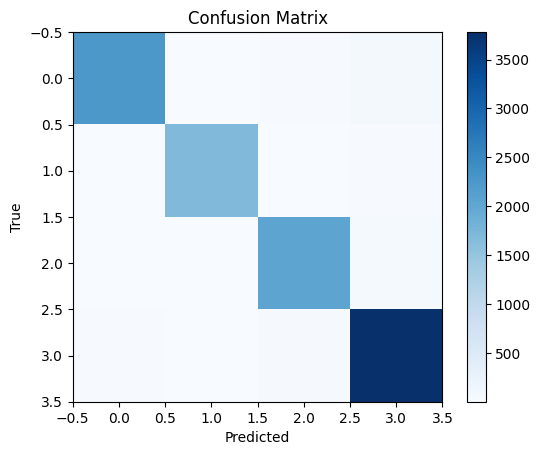

In [ ]:
# =============================
# Restore Vocabulary
# =============================
# Important: vocab must be restored exactly as used during training,
# otherwise token-ID mapping will mismatch and predictions will be wrong.
vocab_loaded = checkpoint["vocab"]

vocab = Vocab([])             # create empty object
vocab.word2idx = vocab_loaded       # restore mapping
vocab.idx2word = {i: w for w, i in vocab_loaded.items()}

label_classes = checkpoint["label_encoder"]   # the original class labels
num_classes = len(label_classes)

# =============================
# Rebuild Model with Saved Config
# =============================
# IMPORTANT: model architecture must match exactly
# the architecture used during training, otherwise weights won't load.
cfg_saved = checkpoint["config"]

final_model = LSTMClassifier(
    vocab_size=len(vocab_loaded),
    embed_dim=cfg_saved["embed_dim"],
    hidden_dim=cfg_saved["hidden_dim"],
    num_classes=num_classes,
    num_layers=cfg_saved["num_layers"],
    dropout=cfg_saved["dropout"]
).to(device)

# Load trained weights into model
final_model.load_state_dict(checkpoint["model_state_dict"])
final_model.eval()
print("✅ Final model restored and ready for inference.")

# =============================
# Build DataLoaders for Evaluation
# =============================
# Must use restored vocab to ensure correct tokenization.
train_loader = DataLoader(TextDataset(train_df, vocab),batch_size=best_batch, shuffle=True)
val_loader = DataLoader(TextDataset(val_df, vocab), batch_size=best_batch, shuffle=False)
test_loader = DataLoader(TextDataset(test_df, vocab), batch_size=best_batch, shuffle=False)
loss_fn = nn.CrossEntropyLoss()

# =============================
# Final Test Evaluation
# =============================
test_loss, test_acc = eval_epoch(final_model, test_loader, loss_fn)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

# =============================
# Collect Predictions
# =============================
@torch.no_grad()
def get_preds(model, loader):
    # IMPORTANT: disable gradients for faster and safer inference
    model.eval()
    y_pred, y_true = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        y_pred.extend(logits.argmax(1).cpu().numpy())
        y_true.extend(yb.numpy())
    return np.array(y_pred), np.array(y_true)

y_pred, y_true = get_preds(final_model, test_loader)

# =============================
# Classification Report
# =============================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_classes))

# =============================
# Confusion Matrix Visualization
# =============================
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

![Metrics.png](https://codefinity-content-media.s3.eu-west-1.amazonaws.com/b71ff7ac-3932-41d2-a4d8-060e24b00129/MetricsSummary.png)